<a href="https://colab.research.google.com/github/parth-u/NullClass-App-Store-Data-Analytics/blob/main/Full%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

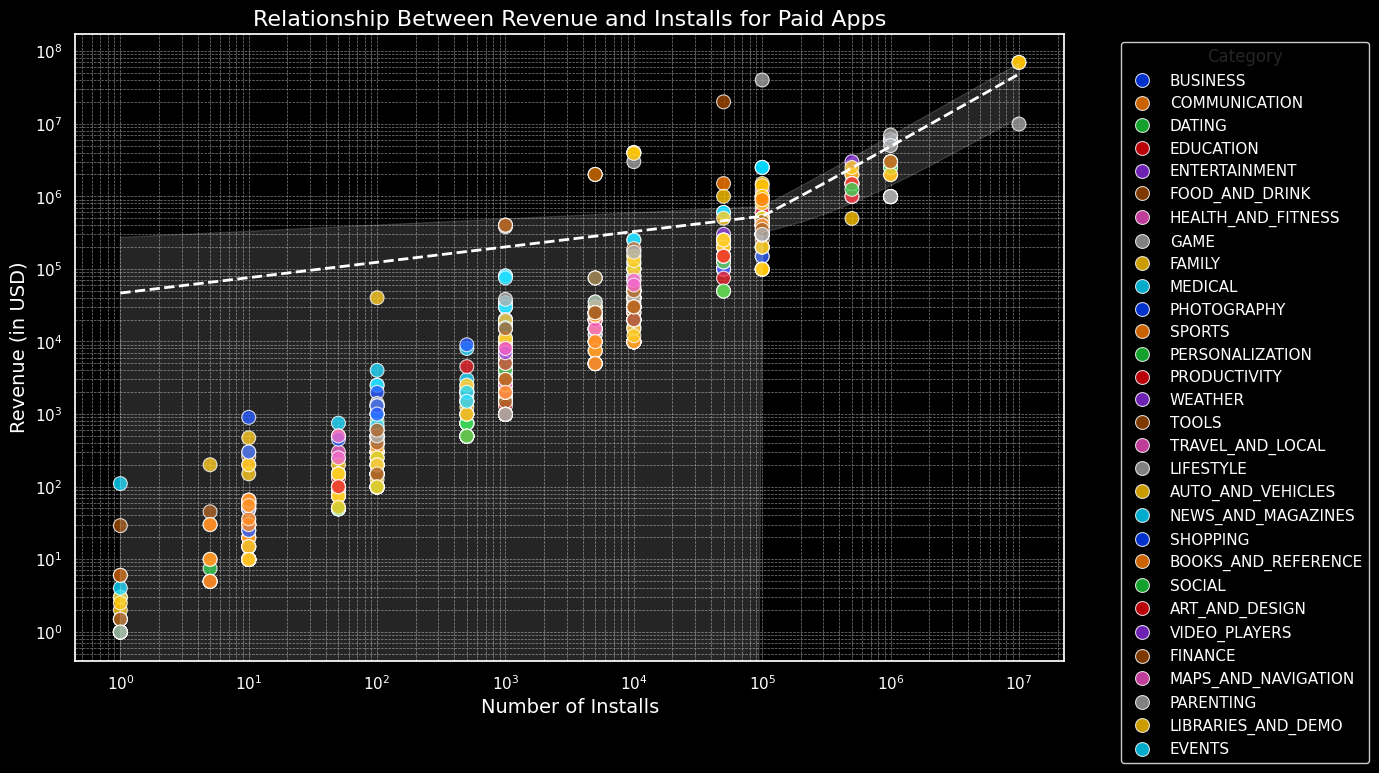

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the data
data = pd.read_csv('/content/sample_data/Play Store Data.csv')

# Data cleaning and preparation
# Filter for paid apps only
paid_apps = data[data['Type'] == 'Paid'].copy()

# Clean and convert `Installs` and `Price` to numeric values
paid_apps['Installs'] = paid_apps['Installs'].str.replace('+', '', regex=False).str.replace(',', '', regex=False).astype(float)
paid_apps['Price'] = paid_apps['Price'].str.replace('$', '', regex=False).astype(float)

# Calculate revenue
paid_apps['Revenue'] = paid_apps['Installs'] * paid_apps['Price']

# Remove rows with missing or zero values in key columns
paid_apps = paid_apps.dropna(subset=['Revenue', 'Installs', 'Category'])
paid_apps = paid_apps[(paid_apps['Revenue'] > 0) & (paid_apps['Installs'] > 0)]

# Set the aesthetic style of the plot
sns.set(style="darkgrid", palette="bright")

# Create the scatter plot with a black background
plt.figure(figsize=(14, 8), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

scatter = sns.scatterplot(
    data=paid_apps,
    x='Installs',
    y='Revenue',
    hue='Category',
    palette='bright',  # Use a bright color palette for better differentiation
    alpha=0.8,
    edgecolor='w',
    s=100
)

# Add a trendline
sns.regplot(
    data=paid_apps,
    x='Installs',
    y='Revenue',
    scatter=False,
    color='white',  # Use white for the trendline to stand out
    line_kws={"linewidth": 2, "linestyle": "dashed"}
)

# Customize the plot
plt.title('Relationship Between Revenue and Installs for Paid Apps', fontsize=16, color='white')
plt.xlabel('Number of Installs', fontsize=14, color='white')
plt.ylabel('Revenue (in USD)', fontsize=14, color='white')
plt.xscale('log')  # Log scale for better visualization of spread
plt.yscale('log')  # Log scale for revenue

# Customize the legend
legend = plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Customize the ticks
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.tight_layout()

# Show the plot
plt.show()

In [9]:
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
import pytz

# Set the timezone to IST
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()

# Define the allowed time window (3 PM - 5 PM IST)
start_time = datetime.strptime("15:00:00", "%H:%M:%S").time()
end_time = datetime.strptime("17:00:00", "%H:%M:%S").time()

# Check if the current time is within the allowed time range
if start_time <= current_time <= end_time:
    # Load the dataset
    file_path = '/content/sample_data/Play Store Data.csv'  # Update path if needed
    data = pd.read_csv(file_path)

    # Data Cleaning
    data['Installs'] = (
        data['Installs']
        .str.replace('[+,]', '', regex=True)
        .str.strip()
    )

    # Remove invalid installs
    data = data[data['Installs'].str.isnumeric()]
    data['Installs'] = data['Installs'].astype(float)

    # Convert 'Size' column
    def convert_size(size):
        if isinstance(size, str):
            if 'M' in size:
                return float(size.replace('M', '')) * 1_000_000
            elif 'k' in size:
                return float(size.replace('k', '')) * 1_000
            elif 'G' in size:
                return float(size.replace('G', '')) * 1_000_000_000
        return None

    data['Size'] = data['Size'].apply(convert_size)

    # Convert 'Last Updated' to datetime
    data['Last Updated'] = pd.to_datetime(data['Last Updated'], errors='coerce')

    # Convert 'Reviews' to numeric
    data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')

    # Apply Filters (Rating ≥ 4.0, Size ≥ 10MB, Last Updated in January)
    filtered_data = data.loc[
        (data['Rating'] >= 4.0) &
        (data['Size'] >= 10_000_000) &
        (data['Last Updated'].dt.month == 1)
    ]

    # Aggregate Data
    aggregated_data = (
        filtered_data.groupby('Category')
        .agg({'Rating': 'mean', 'Reviews': 'sum', 'Installs': 'sum'})
        .reset_index()
    )

    # Select Top 10 Categories by Installs
    top_categories = aggregated_data.nlargest(10, 'Installs').copy()

    # Apply Log Scaling to Reviews
    top_categories['Reviews'] = top_categories['Reviews'].fillna(1).astype(float)
    top_categories['Reviews'] = top_categories['Reviews'].apply(lambda x: max(1, x))

    # Create Grouped Bar Chart
    fig = go.Figure()

    # Add bars for average rating
    fig.add_trace(
        go.Bar(
            x=top_categories['Category'],
            y=top_categories['Rating'],
            name='Average Rating',
            marker_color='#1f77b4',
            text=top_categories['Rating'].round(2),
            textposition='auto'
        )
    )

    # Add bars for total reviews (log scale applied)
    fig.add_trace(
        go.Bar(
            x=top_categories['Category'],
            y=top_categories['Reviews'],
            name='Total Reviews (Log Scale)',
            marker_color='#ff7f0e',
            text=top_categories['Reviews'].apply(lambda x: f"{x:.0f}"),
            textposition='auto'
        )
    )

    # Update layout for dark theme
    fig.update_layout(
        title={
            'text': 'Comparison of Average Rating and Total Reviews for Top 10 Categories',
            'x': 0.5,
            'font': {'size': 20, 'color': 'white'}
        },
        xaxis_title='Category',
        yaxis_title='Value',
        barmode='group',
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(
            tickfont=dict(color='white'),
            gridcolor='gray'
        ),
        yaxis=dict(
            tickfont=dict(color='white'),
            gridcolor='gray',
            type='log'
        ),
        legend=dict(
            font=dict(color='white')
        )
    )

    # Show the figure
    fig.show()
else:
    print("⚠️ This graph can only be viewed between 3 PM and 5 PM IST.")


⚠️ This graph can only be viewed between 3 PM and 5 PM IST.


In [ ]:
!pip install pandas plotly pytz
import pandas as pd
from datetime import datetime
import pytz
import plotly.express as px

# Load Data
data = pd.read_csv('/content/sample_data/Play Store Data.csv')

# Data Cleaning
data = data[data['Installs'].str.replace('[+,]', '', regex=True).str.isnumeric()]
data['Installs'] = data['Installs'].str.replace('[+,]', '', regex=True).astype(float)

# Filter Categories
filtered_data = data[~data['Category'].str.startswith(('A', 'C', 'G', 'S'))]
filtered_data = filtered_data[filtered_data['Installs'] > 1_000_000]

# Aggregate installs by category
category_installs = filtered_data.groupby('Category')['Installs'].sum().reset_index()

# Select Top 5 Categories
top_categories = category_installs.nlargest(5, 'Installs')
top_categories['Country'] = ['USA', 'India', 'Brazil', 'Russia', 'Germany']  # Example country mapping

# Time-based Restriction
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()
start_time = datetime.strptime("18:00", "%H:%M").time()
end_time = datetime.strptime("20:00", "%H:%M").time()

if start_time <= current_time <= end_time:
    # Create Choropleth Map with Dark Theme
    fig = px.choropleth(
        top_categories,
        locations="Country",
        locationmode="country names",
        color="Installs",
        hover_name="Category",
        title="Global Installs by Top App Categories",
        color_continuous_scale=px.colors.sequential.Viridis,  # Vibrant Color
    )

    # Layout Customization
    fig.update_layout(
        paper_bgcolor="black",
        plot_bgcolor="black",
        font=dict(color="white"),  # White font for visibility
        title_x=0.5,
        margin={"r": 0, "t": 50, "l": 0, "b": 0},
    )

    fig.show()
else:
    print("The graph is not available outside the time range of 6 PM to 8 PM IST.")


The graph is not available outside the time range of 6 PM to 8 PM IST.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

# Load dataset
file_path = "/content/sample_data/Play Store Data.csv"
df = pd.read_csv(file_path)

# Convert 'Installs' column: Remove non-numeric values
df['Installs'] = df['Installs'].astype(str).str.replace(r'[^\d]', '', regex=True)

# Convert to numeric and drop NaNs (invalid rows)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
df = df.dropna(subset=['Installs'])

# Convert 'Last Updated' to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# Filter data based on conditions
filtered_df = df[
    (df['Content Rating'] == 'Teen') &
    (df['App'].str.startswith('E', na=False)) &
    (df['Installs'] > 10000)
]

# Group by Month & Category
filtered_df['Year-Month'] = filtered_df['Last Updated'].dt.to_period('M')
grouped_df = filtered_df.groupby(['Year-Month', 'Category'])['Installs'].sum().reset_index()

# Convert Year-Month to datetime
grouped_df['Year-Month'] = grouped_df['Year-Month'].astype(str)
grouped_df['Year-Month'] = pd.to_datetime(grouped_df['Year-Month'])

# Calculate MoM Growth
grouped_df['Prev Month Installs'] = grouped_df.groupby('Category')['Installs'].shift(1)
grouped_df['MoM Growth %'] = ((grouped_df['Installs'] - grouped_df['Prev Month Installs']) / grouped_df['Prev Month Installs']) * 100
grouped_df['Highlight Growth'] = grouped_df['MoM Growth %'] > 20  # Identify periods with >20% growth

# Get current time in IST
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.datetime.now(ist).time()
start_time = datetime.time(18, 0)  # 6 PM IST
end_time = datetime.time(21, 0)  # 9 PM IST

if start_time <= current_time <= end_time:
    # Create plot
    plt.figure(figsize=(12, 6), facecolor='black')
    categories = grouped_df['Category'].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(categories)))

    # Plot each category
    for cat, color in zip(categories, colors):
        category_data = grouped_df[grouped_df['Category'] == cat]
        plt.plot(category_data['Year-Month'], category_data['Installs'], label=cat, color=color, linewidth=2)
        plt.fill_between(category_data['Year-Month'], category_data['Installs'], where=category_data['Highlight Growth'], color='red', alpha=0.3)

    # Customize plot
    plt.xlabel("Date", fontsize=14, color='white')
    plt.ylabel("Total Installs", fontsize=14, color='white')
    plt.title("Total Installs Over Time by Category", fontsize=16, color='white')
    plt.xticks(color='white', rotation=45)
    plt.yticks(color='white')
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.gca().set_facecolor("black")  # Black background

    # Show plot
    plt.show()
else:
    print("Graph can only be viewed between 6 PM IST and 9 PM IST.")


Graph can only be viewed between 6 PM IST and 9 PM IST.


<ipython-input-23-dd6b174c904d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year-Month'] = filtered_df['Last Updated'].dt.to_period('M')


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz  # For timezone conversion

# Load the dataset
file_path = '/content/sample_data/Play Store Data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Data Cleaning
# Convert Installs to numeric
data['Installs'] = data['Installs'].str.replace('[+,]', '', regex=True)
data = data[data['Installs'].str.isnumeric()]  # Remove invalid rows
data['Installs'] = data['Installs'].astype(float)

# Convert Reviews to numeric
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')

# 📊 Check data distribution before filtering
print("\n📌 Dataset Overview Before Filtering")
print(data[['Installs', 'Reviews']].describe())

# 🚀 Set Dynamic Filters Based on Data
min_installs = max(1000, data['Installs'].quantile(0.05))  # Ensures reasonable threshold
min_reviews = max(50, data['Reviews'].quantile(0.05))  # Ensures reasonable threshold

print(f"\n🔍 Filter Values: Installs ≥ {min_installs}, Reviews ≥ {min_reviews}")

# 🔹 Step 1: Remove date filter completely
filtered_data = data.copy()
print(f"After removing date filter: {filtered_data.shape}")

# 🔹 Step 2: Apply install & review filters
filtered_data = filtered_data[(filtered_data['Installs'] >= min_installs) & (filtered_data['Reviews'] >= min_reviews)]
print(f"After installs & reviews filtering: {filtered_data.shape}")

# 🔹 Step 3: Exclude only a few genres
excluded_letters = ('X', 'Y', 'Z')  # Excluding rare genres only
filtered_data = filtered_data[~filtered_data['Genres'].str.startswith(excluded_letters, na=False)]
print(f"After genres filtering: {filtered_data.shape}")

# Select relevant columns for correlation matrix
filtered_data = filtered_data[['Installs', 'Rating', 'Reviews']].dropna()
print(f"Final dataset size before correlation: {filtered_data.shape}")

# ⏰ Time Restriction: Show Graph Only Between 2 PM - 4 PM IST
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()
start_time = datetime.strptime("14:00:00", "%H:%M:%S").time()
end_time = datetime.strptime("16:00:00", "%H:%M:%S").time()

if start_time <= current_time <= end_time:
    if filtered_data.empty:
        print("❌ No data left after filtering! Try reducing the filters further.")
    else:
        # Generate the correlation matrix
        corr_matrix = filtered_data.corr()
        print("📊 Correlation Matrix:\n", corr_matrix)

        # Plot the heatmap with a dark theme
        plt.figure(figsize=(8, 6), facecolor='black')  # Dark background
        sns.set_style("dark")  # Dark style for aesthetics

        heatmap = sns.heatmap(
            corr_matrix,
            annot=True,
            cmap='magma',  # Vibrant color map
            fmt='.2f',
            linewidths=1,
            linecolor='black',
            annot_kws={"size": 12, "color": "white"}  # White text
        )

        plt.title('Correlation Matrix for Filtered Data', fontsize=14, color='white')  # White title
        plt.xticks(color='white')  # White axis labels
        plt.yticks(color='white')  # White axis labels
        plt.show()
else:
    print("⏳ Graph not available outside allowed hours (2 PM - 4 PM IST).")



📌 Dataset Overview Before Filtering
           Installs       Reviews
count  1.084000e+04  1.084000e+04
mean   1.546434e+07  4.441529e+05
std    8.502936e+07  2.927761e+06
min    0.000000e+00  0.000000e+00
25%    1.000000e+03  3.800000e+01
50%    1.000000e+05  2.094000e+03
75%    5.000000e+06  5.477550e+04
max    1.000000e+09  7.815831e+07

🔍 Filter Values: Installs ≥ 1000, Reviews ≥ 50
After removing date filter: (10840, 13)
After installs & reviews filtering: (7923, 13)
After genres filtering: (7923, 13)
Final dataset size before correlation: (7859, 3)
⏳ Graph not available outside allowed hours (2 PM - 4 PM IST).


In [10]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash_bootstrap_components as dbc
import datetime

# Load the dataset
data = pd.read_csv('/content/sample_data/Play Store Data.csv')
data['Installs'] = (
    data['Installs']
    .astype(str)
    .str.replace(r'[+,]', '', regex=True)
    .replace('Free', '0')  # Handle 'Free' values
    .astype(float)
)
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')

data['Type'] = data['Type'].fillna('Free')

def is_within_time_range(start_hour, end_hour):
    now = datetime.datetime.now().time()
    return start_hour <= now.hour < end_hour

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.CYBORG])
server = app.server

app.layout = html.Div([
    html.H1("Play Store Data Analysis Dashboard", style={'textAlign': 'center', 'color': 'cyan'}),
    html.Hr(),
    dcc.Tabs(id="tabs", value='tab1', children=[
        dcc.Tab(label='Revenue vs. Installs', value='tab1', style={'backgroundColor': '#333', 'color': 'white'}),
        dcc.Tab(label='Ratings & Reviews per Category', value='tab2', style={'backgroundColor': '#333', 'color': 'white'}),
        dcc.Tab(label='Installs by Category (Map)', value='tab3', style={'backgroundColor': '#333', 'color': 'white'}),
        dcc.Tab(label='Install Trends Over Time', value='tab4', style={'backgroundColor': '#333', 'color': 'white'}),
        dcc.Tab(label='Correlation Matrix', value='tab5', style={'backgroundColor': '#333', 'color': 'white'}),
    ], style={'backgroundColor': '#222'}),
    html.Div(id='tabs-content', style={'backgroundColor': '#111', 'padding': '20px', 'borderRadius': '10px'}),
    html.Button("Download Dashboard", id="download-button", style={'margin': '20px'}),
    dcc.Download(id="download-dashboard")
])

@app.callback(
    Output('tabs-content', 'children'),
    Input('tabs', 'value')
)
def update_tab(tab_name):
    if tab_name == 'tab1':
        return dcc.Graph(figure=update_scatter_plot())
    elif tab_name == 'tab2' and is_within_time_range(15, 17):
        return dcc.Graph(figure=update_grouped_bar_chart())
    elif tab_name == 'tab3' and is_within_time_range(18, 20):
        return dcc.Graph(figure=update_choropleth_map())
    elif tab_name == 'tab4' and is_within_time_range(18, 21):
        return dcc.Graph(figure=update_time_series())
    elif tab_name == 'tab5' and is_within_time_range(14, 16):
        return dcc.Graph(figure=update_heatmap())
    else:
        return html.H3("This section is not available at this time.", style={'textAlign': 'center', 'color': 'red'})

@app.callback(
    Output("download-dashboard", "data"),
    Input("download-button", "n_clicks"),
    prevent_initial_call=True
)
def download_dashboard(n_clicks):
    with open("dashboard.html", "w") as file:
        file.write(app.index_string)
    return dcc.send_file("dashboard.html")

# Functions for analysis

def update_scatter_plot():
    paid_apps = data[data['Type'] == 'Paid'].copy()
    paid_apps['Revenue'] = paid_apps['Installs'] * paid_apps['Price'].str.replace('$', '', regex=False).astype(float)
    fig = px.scatter(paid_apps, x='Installs', y='Revenue', color='Category', log_x=True, log_y=True, title='Revenue vs. Installs for Paid Apps')
    fig.update_layout(template='plotly_dark')
    return fig

def update_grouped_bar_chart():
    filtered_data = data.groupby('Category').agg({'Rating': 'mean', 'Reviews': 'sum'}).reset_index()
    fig = go.Figure()
    fig.add_trace(go.Bar(x=filtered_data['Category'], y=filtered_data['Rating'], name='Average Rating', marker_color='cyan'))
    fig.add_trace(go.Bar(x=filtered_data['Category'], y=filtered_data['Reviews'], name='Total Reviews', yaxis='y2', marker_color='magenta'))
    fig.update_layout(title='Ratings & Reviews per Category', yaxis=dict(title='Average Rating'), yaxis2=dict(title='Total Reviews', overlaying='y', side='right', type='log'), barmode='group', template='plotly_dark')
    return fig

def update_choropleth_map():
    category_installs = data.groupby('Category', as_index=False)['Installs'].sum()
    top_categories = category_installs.nlargest(5, 'Installs')
    top_categories['Country'] = ['USA', 'India', 'Brazil', 'Russia', 'Germany']
    fig = px.choropleth(top_categories, locations="Country", locationmode="country names", color="Installs", hover_name="Category", title="Global Installs by Top App Categories")
    fig.update_layout(template='plotly_dark')
    return fig

def update_time_series():
    df = data.copy()
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    df['Year-Month'] = df['Last Updated'].dt.to_period('M')
    grouped_df = df.groupby(['Year-Month', 'Category'])['Installs'].sum().reset_index()
    grouped_df['Year-Month'] = grouped_df['Year-Month'].astype(str)
    grouped_df['Year-Month'] = pd.to_datetime(grouped_df['Year-Month'])
    fig = px.line(grouped_df, x='Year-Month', y='Installs', color='Category', title="Install Trends Over Time by Category")
    fig.update_layout(template='plotly_dark')
    return fig

def update_heatmap():
    numeric_data = data[['Installs', 'Rating', 'Reviews']].dropna()
    corr_matrix = numeric_data.corr()
    fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='Viridis', title="Correlation Matrix for Filtered Data")
    fig.update_layout(template='plotly_dark')
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)


<IPython.core.display.Javascript object>